In [ ]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras import optimizers
import pickle

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [ ]:
# import tensorflow as tf
# tf.test.gpu_device_name()

''

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive') 
# path = '/content/gdrive/MyDrive/IFT 6390/kaggle2/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


establish parameters for training

In [ ]:

NUM_EPOCHS = 30  # Number of epochs we usually start to train with
BATCH_SIZE = 128  # Size of the batches used in the mini-batch gradient descent
NUM_WORDS = 8192

corpus_col = 'text_lemmatized'
INPUT_PATH = path+'data/input/'  # Path where all input files are stored
model_output_file = path + 'data/output/neural_network/neural_network_model.h5'
train_history_output_file = path + 'data/output/neural_network/train_history.pkl'

load embeddings <br>
note: these pre-trained embeddings were not used to get the final results

In [ ]:
# vectors = []
# with open(path+'vectors.tsv') as f:
#     for line in f:
#         v = np.array([float(l) for l in line.split()])
#         vectors.append(v)

# words = []
# with open(path+'metadata.tsv') as f:
#     for word in f:
  
#         words.append(word.strip())


# Data Preparation
### Read and clean data

In [ ]:
train = pd.read_csv(INPUT_PATH+'train_data_prepped.csv')
test = pd.read_csv(INPUT_PATH+'test_data_prepped.csv')

In [ ]:
test = test.fillna('')

In [ ]:
train_labels =  pd.read_csv(INPUT_PATH+'train_results.csv')

In [ ]:
train_labels['target'].value_counts()

positive    520436
negative    519803
neutral         84
Name: target, dtype: int64

In [ ]:
train['target'] = train_labels['target']

In [ ]:
train.head(1)

,id,text,cat,text_no_punc,text_no_numerals,text_no_sw,text_porter_stemmed,text_lancaster_stemmed,text_lemmatized,target
0,0,anyway im getting of for a while,train,anyway im getting of for a while,anyway im getting of for a while,anyway im getting,anyway im get of for a while,anyway im get of for a whil,anyway im getting of for a while,positive


remove null rows

In [ ]:
train = train[~train.isnull().any(axis=1)]

In [ ]:
test = test[~test.isnull().any(axis=1)]

remove neutral class

In [ ]:
train = train[train['target'] != 'neutral']
train['target'].value_counts()

positive    518740
negative    517890
Name: target, dtype: int64

In [ ]:
train.head(3)

,id,text,cat,text_no_punc,text_no_numerals,text_no_sw,text_porter_stemmed,text_lancaster_stemmed,text_lemmatized,target
0,0,anyway im getting of for a while,train,anyway im getting of for a while,anyway im getting of for a while,anyway im getting,anyway im get of for a while,anyway im get of for a whil,anyway im getting of for a while,positive
1,1,"my red, apache isn't feelin too well this morn...",train,my red apache isnt feelin too well this morning,my red apache isnt feelin too well this morning,red apache feelin well morning,my red apach isnt feelin too well thi morn,my red apach isnt feelin too wel thi morn,my red apache isnt feelin too well this morning,negative
2,2,you should be its great. friday will be great ...,train,you should be its great friday will be great t...,you should be its great friday will be great t...,great friday great tooooooo,you should be it great friday will be great to...,you should be it gre friday wil be gre tooooooo,you should be it great friday will be great to...,positive


In [ ]:
def deep_model(model, X_train, y_train, X_valid, y_valid, es, lr_schedule, model_file, train_history_file):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer=optimizers.Adamax(lr=0.05)
                  , loss='binary_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NUM_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1
                       , callbacks=[es, lr_schedule])
    
    model.save(model_file)

    with open(train_history_file, 'wb') as file_pi:
      pickle.dump(history, file_pi)

    # It can be used to reconstruct the model identically.
    
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NUM_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results



### Train-Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train[corpus_col], train['target'].values, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 932967
# Test data samples: 103663


In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(932967,) (932967,) (103663,) (103663,)


### create token sequences

In [ ]:
tokenizer = Tokenizer(num_words=NUM_WORDS,
               filters='"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

### Creating word sequences of equal length


In [ ]:

seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    932967.000000
mean         12.620634
std           6.920303
min           1.000000
25%           7.000000
50%          12.000000
75%          18.000000
max         228.000000
Name: text_lemmatized, dtype: float64

In [ ]:
seq_lengths.quantile(0.99)

28.0

In [ ]:
MAX_LEN = int(seq_lengths.quantile(0.99))  # Maximum number of words in a sequence
MAX_LEN 

28

set MAX_LEN to 28, pad shorter sequences with zeros

In [ ]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)


### Converting the target classes to numbers

In [ ]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

### Splitting off validation data

In [ ]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print(X_train_emb.shape, y_train_emb.shape, X_valid_emb.shape, y_valid_emb.shape)

(839670, 28) (839670, 2) (93297, 28) (93297, 2)


# Modeling

### Training model<br> 

#### estblish learning rate scheduler

In [ ]:

def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

establish early stopper

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)


create model architecture

In [ ]:
emb_model2 = models.Sequential()
emb_model2.add(layers.Embedding(NUM_WORDS, 64, input_length=MAX_LEN))
emb_model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.5)))
emb_model2.add(layers.Flatten())
emb_model2.add(layers.Dense(2, activation='softmax'))
emb_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 28, 64)            524288    
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               13600     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 82        
                                                                 
Total params: 537,970
Trainable params: 537,970
Non-trainable params: 0
_________________________________________________________________


In [ ]:
emb_history2 = deep_model(emb_model2, 
                          X_train_emb, 
                          y_train_emb, 
                          X_valid_emb, 
                          y_valid_emb, 
                          early_stop,
                          schedule, 
                          model_file=model_output_file, 
                          train_history_file=train_history_output_file)

Epoch 1/3


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adamax.py:95: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


6560/6560 [==============================] - 320s 48ms/step - loss: 0.4465 - accuracy: 0.7912 - val_loss: 0.4235 - val_accuracy: 0.8054 - lr: 0.0500
Epoch 2/3
6560/6560 [==============================] - 275s 42ms/step - loss: 0.4260 - accuracy: 0.8038 - val_loss: 0.4235 - val_accuracy: 0.8047 - lr: 0.0500
Epoch 3/3
6560/6560 [==============================] - 274s 42ms/step - loss: 0.4217 - accuracy: 0.8062 - val_loss: 0.4222 - val_accuracy: 0.8056 - lr: 0.0500


load saved model

In [ ]:
# emb_history2 = models.load_model(path+model_output_file)
# with open(path+train_history_output_file, "rb") as file_pi:
#     emb_history2 = pickle.load(file_pi)

evaluate model on holdout

In [1]:
eval_metric(emb_history2, 'accuracy')


In [ ]:
holdout_predictions = emb_model2.predict(X_test_seq_trunc).argmax(axis=-1)

3240/3240 [==============================] - 27s 8ms/step


In [ ]:
num_correct = 0
for p, a in zip(holdout_predictions, y_test_oh):
  pos = a[1]
  
  if p==pos:
    num_correct+=1

accuracy = num_correct/len(holdout_predictions)
accuracy

0.8052921485968957

### evaluate model on true kaggle test data

In [ ]:
test.head(3)

,id,text,cat,text_no_punc,text_no_numerals,text_no_sw,text_porter_stemmed,text_lancaster_stemmed,text_lemmatized
0,0,so cut... missed out on all the tce extreme me...,test,so cut missed out on all the tce extreme merch...,so cut missed out on all the tce extreme merch...,cut missed tce extreme merch! sizes,so cut miss out on all the tce extrem merch! i...,so cut miss out on al the tce extrem merch! in...,so cut missed out on all the tce extreme merch...
1,1,thank you very much wasin this is awesome lol,test,thank you very much wasin this is awesome lol,thank you very much wasin this is awesome lol,thank much wasin awesome lol,thank you veri much wasin thi is awesom lol,thank you very much wasin thi is awesom lol,thank you very much wasin this is awesome lol
2,2,squeezing in some internet time before dustin ...,test,squeezing in some internet time before dustin ...,squeezing in some internet time before dustin ...,squeezing internet time dustin goes work,squeez in some internet time befor dustin goe ...,squeez in som internet tim bef dustin goe to work,squeezing in some internet time before dustin ...


In [ ]:
X_true_test_seq = tokenizer.texts_to_sequences(test[corpus_col])

In [ ]:
X_true_test_seq_trunc = pad_sequences(X_true_test_seq, maxlen=MAX_LEN)

In [ ]:
predictions = emb_model2.predict(X_true_test_seq_trunc)

17506/17506 [==============================] - 92s 5ms/step


In [ ]:
predictions = [p if p==0 else 2 for p in predictions.argmax(axis=-1)]

In [ ]:
predictions[:5]

[0, 2, 0, 0, 0]

In [ ]:
pdf = pd.DataFrame(predictions).reset_index()
pdf.columns  = ['id', 'target']
pdf['target'].value_counts()


0    289030
2    271145
Name: target, dtype: int64

In [ ]:
pdf.to_csv(path+f'/data/output/embedding_{corpus_col}_predictions_2.csv', index=False)

ROC Curve<br>
surce: https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_le, holdout_predictions)

In [ ]:

auc_keras = auc(fpr_keras, tpr_keras)

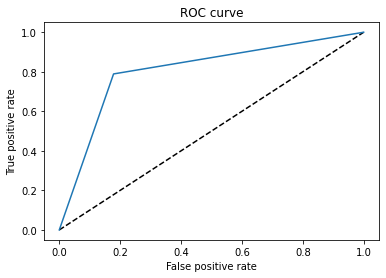

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig(path+'data/output/neural_network/ROC.png')
plt.show()
